In [1]:
'''
This is a TensorFlow implementation of the paper:
Eigen, David, Christian Puhrsch, and Rob Fergus. "Depth map prediction from a single 
image using a multi-scale deep network." Advances in neural information processing 
systems 27 (2014).

This is still a work in progress, as there are many features to be still implemented.
'''

'\nThis is a TensorFlow implementation of the paper:\nEigen, David, Christian Puhrsch, and Rob Fergus. "Depth map prediction from a single \nimage using a multi-scale deep network." Advances in neural information processing \nsystems 27 (2014).\n\nThis is still a work in progress, as there are many features to be still implemented.\n'

In [2]:
import os
os.environ["PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION"] = "python" # solved an error I was getting in Jupyter, may not be needed

import tensorflow as tf
import h5py
import numpy as np
from skimage.transform import resize
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import logging
from tensorflow.keras import layers, models
from tensorflow.keras.losses import Loss
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from tensorflow.keras import backend as K

# Set the TensorFlow logging level to suppress warnings (0 = all messages)
tf.get_logger().setLevel(logging.ERROR)

AUTOTUNE = tf.data.experimental.AUTOTUNE

In [3]:
class CoarseNet(tf.keras.Model):
    '''
    This is the base custom model for the coarse network as described in the paper.
    '''
    
    def __init__(self, custom_optimizers=None):
        super(CoarseNet, self).__init__()
        
        self.coarse1 = models.Sequential([
            layers.Conv2D(96, (11, 11), strides=4, input_shape=(228, 304, 3), kernel_initializer='uniform', name='coarse1_conv'),
            layers.ReLU(name='coarse1_relu'),
            layers.MaxPooling2D(pool_size=(2, 2), name='coarse1_maxpool'),
        ])
        
        self.coarse2 = models.Sequential([
            layers.Conv2D(256, (5, 5), padding='same', kernel_initializer='uniform', name='coarse2_conv'),
            layers.ReLU(name='coarse2_relu'),
            layers.MaxPooling2D(pool_size=(2, 2), name='coarse2_maxpool'),
        ])
        
        self.coarse3 = models.Sequential([
            layers.Conv2D(384, (3, 3), padding='same', kernel_initializer='uniform', name='coarse3_conv'),
            layers.ReLU(name='coarse3_relu'),
        ])
        
        self.coarse4 = models.Sequential([
            layers.Conv2D(384, (3, 3), padding='same', kernel_initializer='uniform', name='coarse4_conv'),
            layers.ReLU(name='coarse4_relu'),
        ])
        
        self.coarse5 = models.Sequential([
            layers.Conv2D(256, (3, 3), strides=2, kernel_initializer='uniform', name='coarse5_conv'),
            layers.ReLU(name='coarse5_relu'),
        ])

        self.coarse6 = models.Sequential([
            layers.Flatten(name='coarse6_flatten'),
            layers.Dense(4096, kernel_initializer='uniform', name='coarse6_dense'),
            layers.ReLU(name='coarse6_relu'),
            layers.Dropout(0.5, name='coarse6_dropout')  # Add dropout here
        ])
        
        self.coarse7 = models.Sequential([
            layers.Dense(74 * 55, activation='linear', name='coarse7_dense'),
        ])
    
    def call(self, inputs):
        coarse_1 = self.coarse1(inputs)
        coarse_2 = self.coarse2(coarse_1)
        coarse_3 = self.coarse3(coarse_2)
        coarse_4 = self.coarse4(coarse_3)
        coarse_5 = self.coarse5(coarse_4)
        coarse_6_1 = tf.keras.layers.Flatten()(coarse_5)
        coarse_6_2 = self.coarse6(coarse_6_1)
        coarse_7_1 = self.coarse7(coarse_6_2)
        coarse_7_2 = tf.reshape(coarse_7_1, [-1, 55, 74])
        
        return coarse_7_2

In [4]:
class FineNet(tf.keras.Model):
    '''
    This is the base custom model for the coarse network as described in the paper.
    '''
    def __init__(self, coarse_model):
        super(FineNet, self).__init__()
        
        self.coarse_model = coarse_model

        # Set coarse model layers as non-trainable
        for layer in coarse_model.layers:
            layer.trainable = False

        self.fine1 = models.Sequential([
            layers.Conv2D(63, (9, 9), strides=2, input_shape=(228, 304, 3), kernel_initializer='uniform', name='fine1_conv'),
            layers.ReLU(name='fine2_relu'),
            layers.MaxPooling2D(pool_size=(2, 2), name='fine2_pool')
        ])

        self.fine2 = models.Sequential([
            layers.Conv2D(64, (5, 5), padding='same', kernel_initializer='uniform', name='fine2_conv'),
            layers.ReLU(name='fine2_relu')
        ])

        self.fine3 = models.Sequential([
            layers.Conv2D(1, (5, 5), padding='same', kernel_initializer='uniform', name='fine2_conv')
        ])


    def call(self, inputs):
        coarse_output = self.coarse_model(inputs, training=False)  # Use the coarse model for inference only
        coarse_output = tf.expand_dims(coarse_output, axis=-1)
        fine_1 = self.fine1(inputs)
        fine_2_1 = layers.Concatenate(axis=-1)([fine_1, coarse_output])  # Concatenate along the channels axis
        fine_2_2 = self.fine2(fine_2_1)
        fine_3 = self.fine3(fine_2_2)
        fine_3 = tf.squeeze(fine_3, axis=-1)
        
        return fine_3

In [5]:
class MetricsCallback(Callback):
    '''
    Define the callbaack for metris we want to follow up on during training.
    Since it is a regression problem, accuracy is not the best metric.
    '''
    def __init__(self):
        super(MetricsCallback, self).__init__()
        self.train_losses = []
        self.train_mses = []
        self.val_losses = []
        self.val_mses = []

    def on_epoch_end(self, epoch, logs=None):
        self.train_losses.append(logs['loss'])
        self.train_mses.append(logs['mse'])
        self.val_losses.append(logs['val_loss'])
        self.val_mses.append(logs['val_mse'])

In [6]:
class ScaleInvariantLoss(tf.keras.losses.Loss):
    '''
    Custom loss as described in the paper.
    '''
    def __init__(self, thr=0.001):
        super(ScaleInvariantLoss, self).__init__()
        self.thr = thr
    
    def call(self, y_true, y_pred):

        first_log = K.log(K.clip(y_pred, K.epsilon(), np.inf) + 1.)
        second_log = K.log(K.clip(y_true, K.epsilon(), np.inf) + 1.)
        scale_invariant_loss =  K.mean(K.square(first_log - second_log), axis=-1) - 0.5 * K.square(K.mean(first_log - second_log, axis=-1))
    
        return scale_invariant_loss

In [7]:
def plot_samples(images, depths, num_samples=5):
    '''
    Given a list of images and depths, plot them for comparission.
    Usage example: 
        num_samples_to_plot = 1
        plot_samples(X_train[:num_samples_to_plot], y_train[:num_samples_to_plot], num_samples=num_samples_to_plot)
    '''

    fig, axes = plt.subplots(2, num_samples, figsize=(15, 5))

    for i in range(num_samples):
        # Display the image (assuming RGB format)
        axes[0, i].imshow(images[i])  # Transpose to (height, width, channels)
        axes[0, i].set_title(f'Image\nmax:{np.max(images[i])} min:{np.min(images[i])}, mean: {np.mean(images[i])}')
        axes[0, i].axis('off')

        # Display the depth map
        axes[1, i].imshow(depths[i], cmap='jet')  # Using 'jet' colormap for depth visualization
        axes[1, i].set_title(f'Depth Map\nmax:{np.max(depths[i])} min:{np.min(depths[i])}, mean: {np.mean(depths[i])}')
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

In [8]:
def display_images_from_dataset(dataset, model, num_samples=5):
    '''
    Iterate over the dataset to extract images and predictions for visual comparission.
    '''
    
    for images, ground_truth in dataset.take(num_samples):
        predictions = model.predict(images)
        display_images(model, images.numpy(), ground_truth.numpy(), predictions)

def display_images(model, images, ground_truth, predictions=None):
    '''
    Define a function to display individual images and predictions.
    For better display, we show no more than 5 images.
    '''
    
    n = len(images) % 5
    plt.figure(figsize=(40, 8))
    plt.suptitle(f'{model.__class__.__name__}')
    
    for i in range(n):
        plt.subplot(3, n, i + 1)
        plt.imshow(images[i])
        plt.title(f'Image\nmax:{np.max(images[i])} min:{np.min(images[i])}, mean: {np.mean(images[i])}')
        plt.axis('off')

        plt.subplot(3, n, i + n + 1)
        plt.imshow(ground_truth[i], cmap='gray')
        plt.title(f'Ground truth\nmax:{np.max(ground_truth[i])} min:{np.min(ground_truth[i])}, mean: {np.mean(ground_truth[i])}')
        plt.axis('off')

        if predictions is not None:
            plt.subplot(3, n, i + 2*n + 1)
            plt.imshow((predictions[i]), cmap='gray')
            plt.title(f'Prediction\nmax:{np.max(predictions[i])} min:{np.min(predictions[i])}, mean: {np.mean(predictions[i])}')
            plt.axis('off')

    plt.tight_layout()
    plt.savefig(f'./images/{model.__class__.__name__}_test_predictions.png')  # Save the plot as an image
    plt.close()

In [9]:
def load_datasets(num_samples_to_load=10, batch_size=32):
    '''
    Load the .mat file using h5py. The dataset can be downloade from https://cs.nyu.edu/~silberman/datasets/nyu_depth_v2.html.
    We are using the Labeled Dataset(2.8G).
    '''
    
    mat_file = 'data/nyu_depth_v2_labeled.mat'
    with h5py.File(mat_file, 'r') as mat_data:
        images = np.array(mat_data['images'][:num_samples_to_load])
        depths = np.array(mat_data['depths'][:num_samples_to_load]) 

    # Reshape the images to the desired dimensions (3, 228, 304)
    resized_images = np.array([resize(img, (3, 304, 228), anti_aliasing=True) for img in images])
    resized_images = resized_images.transpose(0, 3, 2, 1)
    resized_depths = np.array([resize(dpth, (74, 55), anti_aliasing=True) for dpth in depths])
    resized_depths = resized_depths.transpose(0, 2, 1)

    # Normalize images to [0, 1]
    images_normalized = resized_images.astype(np.float32)

    # Scale depths to a specific range (e.g., [0, 1])
    depth_min = np.min(resized_depths)
    depth_max = np.max(resized_depths)
    depths_scaled = (resized_depths - depth_min) / (depth_max - depth_min)

    # Split the dataset into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(images_normalized, depths_scaled, test_size=0.05, random_state=42)

    # Further split the training set into train and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=42)

    # Create TensorFlow datasets
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
    test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

    # Specify batch size and enable shuffling and prefetching
    train_dataset = train_dataset.shuffle(buffer_size=len(X_train)).batch(batch_size).prefetch(buffer_size=AUTOTUNE)
    val_dataset = val_dataset.batch(batch_size).prefetch(buffer_size=AUTOTUNE)
    test_dataset = test_dataset.batch(batch_size).prefetch(buffer_size=AUTOTUNE)

    # Data stats
    print(f'Max depth: {np.max(depths_scaled)} / Min depth: {np.min(depths_scaled)}')
    print(f'Max image pixel value: {np.max(images_normalized)} / Min image pixel value: {np.min(images_normalized)}')

    # Print the shapes of the datasets
    print("X_train shape:", X_train.shape)
    print("y_train shape:", y_train.shape)
    print("X_val shape:", X_val.shape)
    print("y_val shape:", y_val.shape)
    print("X_test shape:", X_test.shape)
    print("y_test shape:", y_test.shape)
    
    return train_dataset, val_dataset, test_dataset

In [10]:
def plot_loss_and_metrics(model, history):
    '''
    Plotting the training loss and metric.
    '''
    plt.figure(figsize=(16, 6))
    plt.suptitle(f'{model.__class__.__name__}')
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['mse'], label='Training MSE')
    plt.plot(history.history['val_mse'], label='Validation MSE')
    plt.xlabel('Epochs')
    plt.ylabel('MSE')
    plt.legend()

    plt.tight_layout()
    plt.savefig(f'./images/{model.__class__.__name__}_train_val_loss_mse.png')
    plt.show()
    plt.close()

In [11]:
# get data
# firstly, we will use few images to try to overfit the model to make sure it is working
train_dataset, val_dataset, test_dataset = load_datasets(num_samples_to_load=10, batch_size=32) # if num_samples_to_load=-1, load all images

Max depth: 1.0 / Min depth: 0.0
Max image pixel value: 0.9921568632125854 / Min image pixel value: 0.0
X_train shape: (7, 228, 304, 3)
y_train shape: (7, 55, 74)
X_val shape: (2, 228, 304, 3)
y_val shape: (2, 55, 74)
X_test shape: (1, 228, 304, 3)
y_test shape: (1, 55, 74)


2023-09-28 10:35:34.472208: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2023-09-28 10:35:34.500691: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:02:00.0 name: Quadro RTX 8000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 47.45GiB deviceMemoryBandwidth: 625.94GiB/s
2023-09-28 10:35:34.501009: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 1 with properties: 
pciBusID: 0000:03:00.0 name: Quadro RTX 8000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 47.45GiB deviceMemoryBandwidth: 625.94GiB/s
2023-09-28 10:35:34.501286: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory
2023-09-28 10:35:34.501396: W tensorflow/stream_executor/platform/d

In [12]:
# instantiate coarse model and start training

coarse_model = CoarseNet()

coarse_metrics_callback = MetricsCallback()
coarse_scale_invariant_loss = ScaleInvariantLoss()
coarse_optimizer = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)
coarse_epochs = 15

coarse_model.compile(optimizer=coarse_optimizer, loss=coarse_scale_invariant_loss, metrics=['mse'])
coarse_history = coarse_model.fit(
                           train_dataset, 
                           epochs=coarse_epochs, 
                           validation_data=val_dataset, 
                           callbacks=[coarse_metrics_callback],
                           verbose=1
                          )

coarse_model.save_weights(f'./log/coarse_model_weights_{coarse_epochs}_epochs_{coarse_optimizer.__class__.__name__}_scaleinvariantloss.h5')

Epoch 1/15
1/1 [==============================] - 0s 273ms/step - loss: 0.1791 - mse: 1.7558 - val_loss: 0.0300 - val_mse: 0.1409
Epoch 2/15
1/1 [==============================] - 0s 38ms/step - loss: 0.0349 - mse: 0.1825 - val_loss: 0.0280 - val_mse: 0.1224
Epoch 3/15
1/1 [==============================] - 0s 40ms/step - loss: 0.0303 - mse: 0.1459 - val_loss: 0.0266 - val_mse: 0.1044
Epoch 4/15
1/1 [==============================] - 0s 37ms/step - loss: 0.0267 - mse: 0.1136 - val_loss: 0.0267 - val_mse: 0.0955
Epoch 5/15
1/1 [==============================] - 0s 43ms/step - loss: 0.0257 - mse: 0.0984 - val_loss: 0.0268 - val_mse: 0.0922
Epoch 6/15
1/1 [==============================] - 0s 37ms/step - loss: 0.0256 - mse: 0.0932 - val_loss: 0.0269 - val_mse: 0.0908
Epoch 7/15
1/1 [==============================] - 0s 39ms/step - loss: 0.0256 - mse: 0.0912 - val_loss: 0.0270 - val_mse: 0.0902
Epoch 8/15
1/1 [==============================] - 0s 37ms/step - loss: 0.0255 - mse: 0.0899 - va

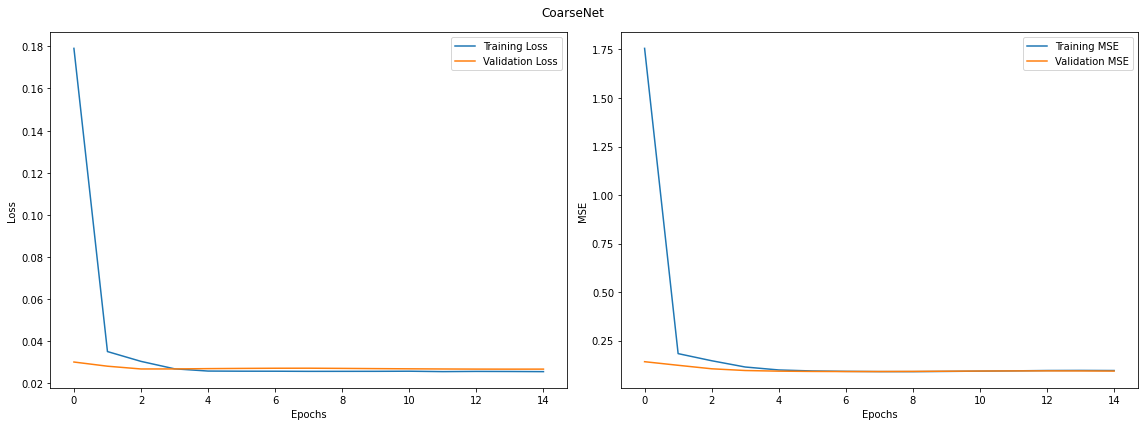

In [13]:
plot_loss_and_metrics(coarse_model, coarse_history)

In [14]:
display_images_from_dataset(test_dataset, coarse_model, num_samples=5)

In [15]:
# instantiate fine model and start training

fine_model = FineNet(coarse_model)

fine_metrics_callback = MetricsCallback()
fine_scale_invariant_loss = ScaleInvariantLoss()
fine_optimizer = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)
fine_epochs = 15

fine_model.compile(optimizer=fine_optimizer, loss=fine_scale_invariant_loss, metrics=['mse'])
fine_history = fine_model.fit(
                           train_dataset, 
                           epochs=fine_epochs, 
                           validation_data=val_dataset, 
                           callbacks=[fine_metrics_callback],
                           verbose=1
                          )

fine_model.save_weights(f'./log/fine_model_weights_{fine_epochs}_epochs_{fine_optimizer.__class__.__name__}_scaleinvariantloss.h5')

Epoch 1/15
1/1 [==============================] - 0s 242ms/step - loss: 0.0284 - mse: 0.1110 - val_loss: 0.0206 - val_mse: 0.0584
Epoch 2/15
1/1 [==============================] - 0s 49ms/step - loss: 0.0208 - mse: 0.0537 - val_loss: 0.1352 - val_mse: 0.6896
Epoch 3/15
1/1 [==============================] - 0s 52ms/step - loss: 0.1518 - mse: 0.7389 - val_loss: 0.0305 - val_mse: 0.1019
Epoch 4/15
1/1 [==============================] - 0s 44ms/step - loss: 0.0294 - mse: 0.0963 - val_loss: 0.0300 - val_mse: 0.0892
Epoch 5/15
1/1 [==============================] - 0s 45ms/step - loss: 0.0290 - mse: 0.0829 - val_loss: 0.0224 - val_mse: 0.0629
Epoch 6/15
1/1 [==============================] - 0s 45ms/step - loss: 0.0223 - mse: 0.0584 - val_loss: 0.0163 - val_mse: 0.0409
Epoch 7/15
1/1 [==============================] - 0s 47ms/step - loss: 0.0202 - mse: 0.0440 - val_loss: 0.0175 - val_mse: 0.0457
Epoch 8/15
1/1 [==============================] - 0s 45ms/step - loss: 0.0215 - mse: 0.0492 - va

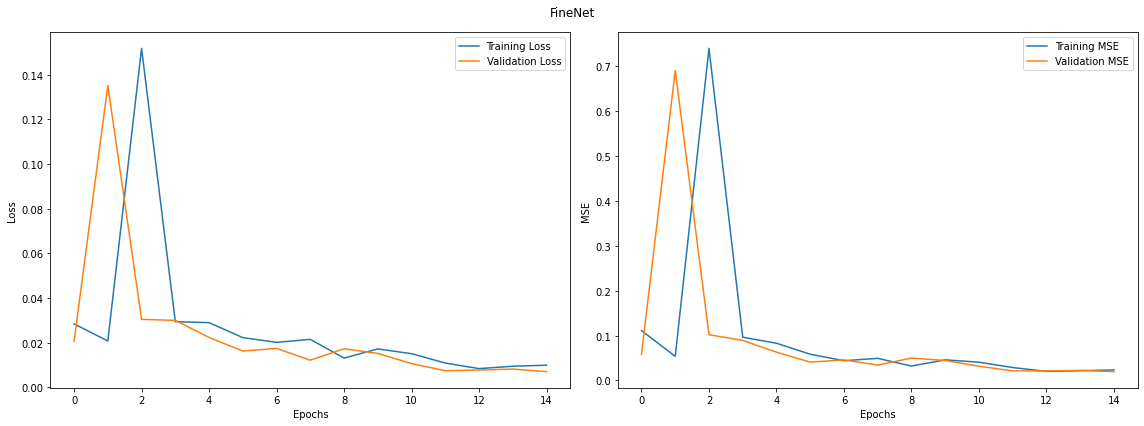

In [16]:
plot_loss_and_metrics(fine_model, fine_history)

In [17]:
display_images_from_dataset(test_dataset, fine_model, num_samples=5)